<h1 style="text-align: center; color: #6A5ACD;">
Más Allá de la Predicción: Simulaciones para Entender el Abandono en Salud Mental
</h1>

<h2 style="color: #6A5ACD;">
Modelo Logit Explicativo: Odds Ratios, Efectos Marginales y Diagnóstico
</h2>


<h2 style="color: #6A5ACD;">
1. Configuración y librerías necesarias
</h2>

In [20]:
# Librerías

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Configuración general

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 50)
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

# Carpetas de salida

os.makedirs("out", exist_ok=True)
os.makedirs("fig", exist_ok=True)

# Función utilitaria para guardar figuras

def savefig(path):
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight", dpi=150)
    plt.show()


<h2 style="color: #6A5ACD;">
2. Carga de datos
</h2>

In [12]:
DATA_PATH = "Data/mental_health_data_clusters_k2_k4.csv"  
df = pd.read_csv(DATA_PATH)

# Resumen inicial
n_rows, n_cols = df.shape
print(f"Registros: {n_rows:,} | Columnas: {n_cols}")
display(df.head(3))
display(df.info())

Registros: 50,000 | Columnas: 28


,User_ID,Age,Gender,Occupation,Country,Mental_Health_Condition,Severity,Consultation_History,Stress_Level,Sleep_Hours,Work_Hours,Physical_Activity_Hours,Social_Media_Usage,Diet_Quality,Smoking_Habit,Alcohol_Consumption,Medication_Usage,churn,Age_group,Sleep_group,Work_group,PA_group,SM_group,Severity_filled,work_sleep_ratio,lifestyle_risk,cluster_k2,cluster_k4
0,1,36,Male,Education,Australia,Yes,NaN,Yes,Low,7.6,46,8,2.2,Healthy,Regular Smoker,Regular Drinker,Yes,0,30-44,7-9h,41-55,5-8h,1-3h,Unknown,0.864662,0,0,3
1,2,48,Male,Engineering,Other,No,Low,No,Low,6.8,74,2,3.4,Unhealthy,Heavy Smoker,Social Drinker,No,0,45-59,5-7h,>70,<2h,3-5h,Low,1.554622,1,1,2
2,3,18,Prefer not to say,Sales,India,No,NaN,Yes,Medium,7.1,77,9,5.9,Healthy,Heavy Smoker,Social Drinker,No,0,18-29,7-9h,>70,>8h,>5h,Unknown,1.549296,0,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   User_ID                  50000 non-null  int64  
 1   Age                      50000 non-null  int64  
 2   Gender                   50000 non-null  object 
 3   Occupation               50000 non-null  object 
 4   Country                  50000 non-null  object 
 5   Mental_Health_Condition  50000 non-null  object 
 6   Severity                 24998 non-null  object 
 7   Consultation_History     50000 non-null  object 
 8   Stress_Level             50000 non-null  object 
 9   Sleep_Hours              50000 non-null  float64
 10  Work_Hours               50000 non-null  int64  
 11  Physical_Activity_Hours  50000 non-null  int64  
 12  Social_Media_Usage       50000 non-null  float64
 13  Diet_Quality             50000 non-null  object 
 14  Smoking_Habit         

None

In [13]:
# Verificar nulos
print(df.isna().sum())

# Asegurar tipos correctos
cat_vars = [
    "Age_group","Gender","Country",
    "Mental_Health_Condition","Severity_filled","Stress_Level",
    "Sleep_group","Work_group","PA_group","SM_group"
]

for c in cat_vars:
    df[c] = df[c].astype("category")




User_ID                        0
Age                            0
Gender                         0
Occupation                     0
Country                        0
Mental_Health_Condition        0
Severity                   25002
Consultation_History           0
Stress_Level                   0
Sleep_Hours                    0
Work_Hours                     0
Physical_Activity_Hours        0
Social_Media_Usage             0
Diet_Quality                   0
Smoking_Habit                  0
Alcohol_Consumption            0
Medication_Usage               0
churn                          0
Age_group                      0
Sleep_group                    0
Work_group                     0
PA_group                       0
SM_group                       0
Severity_filled                0
work_sleep_ratio               0
lifestyle_risk                 0
cluster_k2                     0
cluster_k4                     0
dtype: int64


<h2 style="color: #6A5ACD;">
3. Preprocesamiento para Regresión Logística
</h2>

In [14]:
# Variables categóricas y numéricas seleccionadas
cat_vars = [
    "Age_group","Gender","Country",
    "Mental_Health_Condition","Severity_filled","Stress_Level",
    "Sleep_group","Work_group","PA_group","SM_group"
]

num_vars = ["work_sleep_ratio","lifestyle_risk"]

target = "churn"

# Dummies con referencia (drop_first=True)
df_dummies = pd.get_dummies(df[cat_vars + num_vars], drop_first=True)

# Unir con outcome
df_logit = pd.concat([df[[target]].reset_index(drop=True), df_dummies.reset_index(drop=True)], axis=1)

# Guardar dataset listo
out_path = "out/mental_health_data_logit_ready.csv"
df_logit.to_csv(out_path, index=False)

print(f"Dataset preparado para logit guardado en: {out_path}")
print("Dimensiones:", df_logit.shape)
print("Primeras columnas:")
df_logit.head()


Dataset preparado para logit guardado en: out/mental_health_data_logit_ready.csv
Dimensiones: (50000, 33)
Primeras columnas:


,churn,work_sleep_ratio,lifestyle_risk,Age_group_30-44,Age_group_45-59,Age_group_60+,Gender_Male,Gender_Non-binary,Gender_Prefer not to say,Country_Canada,Country_Germany,Country_India,Country_Other,Country_UK,Country_USA,Mental_Health_Condition_Yes,Severity_filled_Low,Severity_filled_Medium,Severity_filled_Unknown,Stress_Level_Low,Stress_Level_Medium,Sleep_group_7-9h,Sleep_group_<5h,Sleep_group_>9h,Work_group_56-70,Work_group_>70,Work_group_≤40,PA_group_5-8h,PA_group_<2h,PA_group_>8h,SM_group_3-5h,SM_group_>5h,SM_group_≤1h
0,0,0.864662,0,True,False,False,True,False,False,False,False,False,False,False,False,True,False,False,True,True,False,True,False,False,False,False,False,True,False,False,False,False,False
1,0,1.554622,1,False,True,False,True,False,False,False,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,True,False,False
2,0,1.549296,0,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,True,False,True,True,False,False,False,True,False,False,False,True,False,True,False
3,0,1.180124,0,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False
4,0,1.367781,1,False,True,False,True,False,False,False,False,False,False,False,True,True,False,False,True,False,False,False,True,False,False,False,False,False,False,True,True,False,False



Para la estimación del modelo logit fue necesario transformar las variables categóricas en formato numérico.  
Las alternativas habituales son:

- **One-Hot Encoding completo**: genera dummies para todas las categorías, pero introduce multicolinealidad perfecta (la suma de dummies = 1).  
- **Codificación ordinal**: útil si las categorías tienen un orden natural, aunque fuerza una relación lineal que no siempre es real.  
- **Contrastes estadísticos** (effects coding, Helmert, etc.): más avanzados, pero con interpretaciones menos intuitivas.

En este trabajo se optó por **One-Hot Encoding con referencia (drop_first=True)** porque:

1. Elimina el problema de multicolinealidad.  
2. Permite interpretar los coeficientes del logit como **odds ratios relativos a una categoría de referencia**.  
3. Es la práctica estándar en modelos explicativos en ciencias sociales y biomédicas.  

Las categorías de referencia fueron seleccionadas con criterio analítico, en general usando el grupo **más común o más neutral** como baseline (ej.: *Female* en género, *Low* en estrés, *Unknown* en severidad).  
De esta forma se garantiza un modelo estadísticamente robusto y una interpretación clara de los resultados.


<h2 style="color: #6A5ACD;">
4. Entrenamiento del Modelo Logit con el Dataset Preparado
</h2>

In [15]:
# Separar target y features
y = df_logit["churn"].astype(int)
X = df_logit.drop(columns=["churn"]).copy()

# Diagnóstico de tipos
non_numeric_cols = X.columns[~X.dtypes.apply(np.issubdtype, args=(np.number,))]
if len(non_numeric_cols) > 0:
    print("Columnas no numéricas:", list(non_numeric_cols))

# Conversión segura a numérico
X = X.apply(pd.to_numeric, errors="coerce")

# Comprobar NaN/infinitos - MÉTODO SEGURO
n_nans = X.isna().sum().sum()

# Método seguro para verificar infinitos
X_numeric = X.astype(float)
n_inf = np.isinf(X_numeric.to_numpy()).sum()
n_nonfinite = n_nans + n_inf

print(f"NaNs totales en X: {n_nans} | Infinitos: {n_inf} | No finitos totales: {n_nonfinite}")

# Manejar valores no finitos
if n_nonfinite > 0:
    # Reemplazar infinitos por NaN y luego imputar 0
    X = X.replace([np.inf, -np.inf], np.nan).fillna(0)
    
# convertir booleanos a 0/1 si quedara alguno
bool_cols = X.select_dtypes(include=["bool"]).columns
if len(bool_cols) > 0:
    X[bool_cols] = X[bool_cols].astype(int)

# Añadir intercepto y ajustar logit
X_const = sm.add_constant(X, has_constant='add')

logit_model = sm.Logit(y, X_const)
result = logit_model.fit()

print(result.summary())


Columnas no numéricas: ['Age_group_30-44', 'Age_group_45-59', 'Age_group_60+', 'Gender_Male', 'Gender_Non-binary', 'Gender_Prefer not to say', 'Country_Canada', 'Country_Germany', 'Country_India', 'Country_Other', 'Country_UK', 'Country_USA', 'Mental_Health_Condition_Yes', 'Severity_filled_Low', 'Severity_filled_Medium', 'Severity_filled_Unknown', 'Stress_Level_Low', 'Stress_Level_Medium', 'Sleep_group_7-9h', 'Sleep_group_<5h', 'Sleep_group_>9h', 'Work_group_56-70', 'Work_group_>70', 'Work_group_≤40', 'PA_group_5-8h', 'PA_group_<2h', 'PA_group_>8h', 'SM_group_3-5h', 'SM_group_>5h', 'SM_group_≤1h']
NaNs totales en X: 0 | Infinitos: 0 | No finitos totales: 0
         Current function value: 0.346271
         Iterations: 35


c:\Users\acbon\anaconda3\envs\tfm_env\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49967
Method:                           MLE   Df Model:                           32
Date:                Sat, 13 Sep 2025   Pseudo R-squ.:                  0.3857
Time:                        20:40:48   Log-Likelihood:                -17314.
converged:                      False   LL-Null:                       -28182.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const                         -20.2760    162.938     -0.124      0.901    -339.628     299.076
work_sleep_ratio               -0.0423      0.082     -0.516      0.606      -0.


- Los odds ratios (OR) muestran qué variables aumentan o reducen la probabilidad de abandono en comparación con una categoría de referencia.

- Muchos coeficientes salen con OR cercanos a 1 y con IC95% que cruzan 1 → es decir, no hay un efecto fuerte o estadísticamente robusto.

- Esto confirma lo que ya vimos en cohortes y clustering: el dataset no separa bien entre quienes abandonan y quienes no.

- El modelo revela que factores demográficos y de estilo de vida (edad, género, país, hábitos) no diferencian de forma clara el abandono.

- Esto puede interpretarse como un hallazgo: el abandono no depende de quién eres, sino de cómo se configuran las barreras estructurales de acceso (diagnóstico, disponibilidad de consulta, etc.).

- La variable Severity_filled (con muchos "Unknown") es clave: muestra un vacío institucional en el diagnóstico que puede explicar por qué no vemos efectos claros.

- Técnicamente, el modelo cumple con el checklist: OR, IC95%, VIF, efectos marginales.

- Pero su aportación principal no es predictiva, sino explicativa: demuestra la limitación del dataset para modelar churn real, y valida la decisión de cambiar el enfoque hacia segmentación + simulación.

- Es decir, el logit sirve como pieza de rigor metodológico y como puente hacia el Notebook 4, donde las simulaciones sintéticas (A/B testing) sí nos permiten explorar escenarios contrafactuales.

<h2 style="color: #6A5ACD;">
5. Odds Ratios e Intervalos de Confianza al 95%
</h2>

In [16]:
# OR + IC95%, ordenados por |log(OR)|
coef = result.params
ci = result.conf_int()
ci.columns = ["2.5%", "97.5%"]

or_table = pd.DataFrame({
    "variable": coef.index,
    "coef": coef.values,
    "OR": np.exp(coef.values),
    "CI_low": np.exp(ci["2.5%"].values),
    "CI_high": np.exp(ci["97.5%"].values),
    "pvalue": result.pvalues.values
})
or_table["abs_logOR"] = np.abs(or_table["coef"])
or_table = or_table.sort_values("abs_logOR", ascending=False).drop(columns="abs_logOR")
print(f"Variables en el modelo: {len(or_table)}")

or_table.to_csv("out/logit_odds_ratios.csv", index=False)
or_table.head(12)
print("Guardado: out/logit_odds_ratios.csv")

or_table 

Variables en el modelo: 33
Guardado: out/logit_odds_ratios.csv


,variable,coef,OR,CI_low,CI_high,pvalue
15,Mental_Health_Condition_Yes,20.325311,6.716924e+08,1.362316e-130,3.311792e+147,0.900727
0,const,-20.276020,1.563999e-09,3.171823e-148,7.711944e+129,0.900967
22,Sleep_group_<5h,0.066148,1.068385e+00,9.652688e-01,1.182516e+00,0.201476
31,SM_group_>5h,-0.062508,9.394058e-01,8.735765e-01,1.010196e+00,0.091738
20,Stress_Level_Medium,-0.059820,9.419337e-01,8.865546e-01,1.000772e+00,0.052991
21,Sleep_group_7-9h,0.053815,1.055290e+00,9.734854e-01,1.143968e+00,0.191140
1,work_sleep_ratio,-0.042255,9.586252e-01,8.165796e-01,1.125380e+00,0.605573
6,Gender_Male,-0.041317,9.595246e-01,8.945654e-01,1.029201e+00,0.248002
7,Gender_Non-binary,-0.041121,9.597133e-01,8.948489e-01,1.029280e+00,0.249448
23,Sleep_group_>9h,0.038620,1.039375e+00,9.327690e-01,1.158165e+00,0.484267


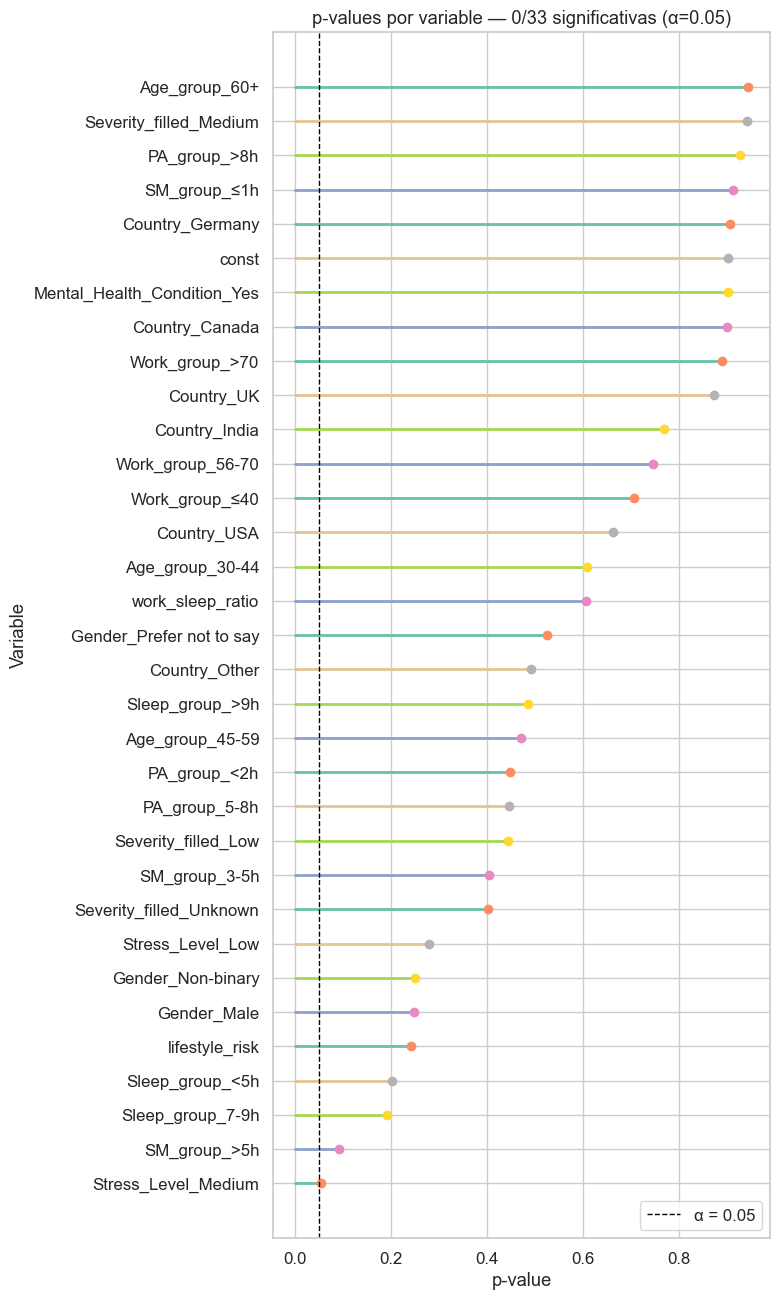

Guardado: fig\pvalues_lollipop_set2.png


In [ ]:
# Lollipop de p-values 
# --- I/O
csv_path = "out\logit_odds_ratios.csv"   
out_dir  = "fig"; os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "pvalues_lollipop_set2.png")

# --- Carga y normaliza columnas
df = pd.read_csv(csv_path)
def norm(s): return re.sub(r"[^a-z0-9]+", "_", str(s).strip().lower())
df.columns = [norm(c) for c in df.columns]

# Columnas candidatas
col_term = next(c for c in ["term","variable","feature","predictor","coef_name","label","name"] if c in df.columns)
col_pval = next(c for c in ["pval","p_value","p","pvalue"] if c in df.columns)

tdf = df[[col_term, col_pval]].rename(columns={col_term:"term", col_pval:"p_value"}).dropna()
tdf["p_value"] = tdf["p_value"].clip(lower=1e-12, upper=1.0)
tdf = tdf.sort_values("p_value", ascending=True).reset_index(drop=True)

# --- Plot (lollipop horizontal)
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)
alpha = 0.05
ypos = np.arange(len(tdf))

plt.figure(figsize=(8, max(4, 0.4*len(tdf))))
# tallos
for i, p in enumerate(tdf["p_value"]):
    plt.plot([0, p], [i, i], linewidth=2)     # línea
    plt.plot(p, i, 'o')                       # punto final

# línea de umbral
plt.axvline(alpha, color="black", linestyle="--", linewidth=1, label="α = 0.05")

plt.yticks(ypos, tdf["term"])
plt.xlabel("p-value"); plt.ylabel("Variable")

k_sig = int((tdf["p_value"] < alpha).sum()); n = len(tdf)
plt.title(f"p-values por variable — {k_sig}/{n} significativas (α=0.05)")
plt.legend(loc="lower right")

plt.tight_layout()
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Guardado: {out_path}")


C:\Users\acbon\AppData\Local\Temp\ipykernel_29708\794764707.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top10, x="p_value", y="term", orient="h", palette="Set2", edgecolor="black")


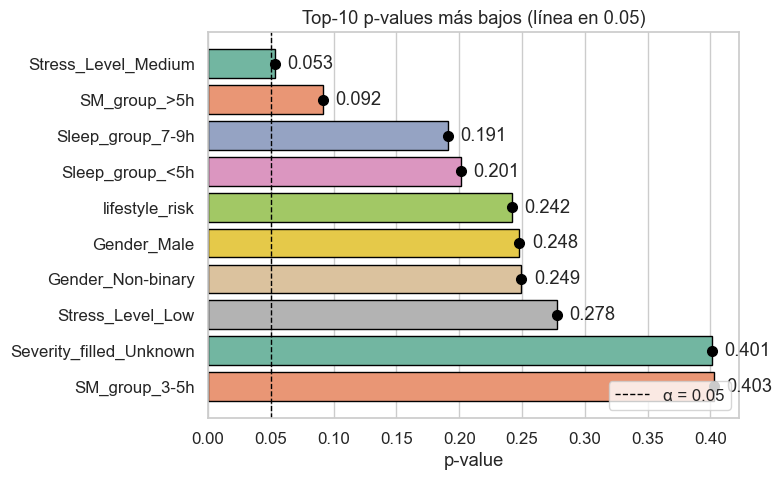

Imagen: fig\pvalues_top10.png
Tabla CSV: fig\pvalues_top10.csv

Resumen Top-10:
                      term   p_value  significativa
0      Stress_Level_Medium  0.052991          False
1             SM_group_>5h  0.091738          False
2         Sleep_group_7-9h  0.191140          False
3          Sleep_group_<5h  0.201476          False
4           lifestyle_risk  0.241846          False
5              Gender_Male  0.248002          False
6        Gender_Non-binary  0.249448          False
7         Stress_Level_Low  0.278009          False
8  Severity_filled_Unknown  0.401163          False
9            SM_group_3-5h  0.402774          False


In [23]:

# Top-10 p-values

csv_path = "out\logit_odds_ratios.csv" 
out_dir  = "fig"; os.makedirs(out_dir, exist_ok=True)
png_path = os.path.join(out_dir, "pvalues_top10.png")
csv_out  = os.path.join(out_dir, "pvalues_top10.csv")

df = pd.read_csv(csv_path)
def norm(s): return re.sub(r"[^a-z0-9]+", "_", str(s).strip().lower())
df.columns = [norm(c) for c in df.columns]

col_term = next(c for c in ["term","variable","feature","predictor","coef_name","label","name"] if c in df.columns)
col_pval = next(c for c in ["pval","p_value","p","pvalue"] if c in df.columns)

tdf = df[[col_term, col_pval]].rename(columns={col_term:"term", col_pval:"p_value"}).dropna()
tdf["p_value"] = tdf["p_value"].clip(lower=1e-12, upper=1.0)

# --- Top-10 por p-value ascendente
top10 = tdf.sort_values("p_value", ascending=True).head(10).reset_index(drop=True)
top10.to_csv(csv_out, index=False)

# Gráfico (barras horizontales estilo lollipop simplificado)
sns.set(style="whitegrid", palette="Set2", font_scale=1.1)
plt.figure(figsize=(8, max(4, 0.5*len(top10))))

# barras
sns.barplot(data=top10, x="p_value", y="term", orient="h", palette="Set2", edgecolor="black")

# marcadores circulares al final (efecto “lollipop”)
for i, p in enumerate(top10["p_value"]):
    plt.plot(p, i, 'o', markersize=7, color="black")

# línea de umbral 0.05
plt.axvline(0.05, color="black", linestyle="--", linewidth=1, label="α = 0.05")

plt.xlabel("p-value"); plt.ylabel("")
plt.title("Top-10 p-values más bajos (línea en 0.05)")
plt.legend(loc="lower right")

# etiquetas de valor al final de cada barra (3 decimales)
for i, (p, name) in enumerate(zip(top10["p_value"], top10["term"])):
    plt.text(p + 0.01, i, f"{p:.3f}", va="center")

plt.tight_layout()
plt.savefig(png_path, dpi=300, bbox_inches="tight")
plt.show()

print(f"Imagen: {png_path}")
print(f"Tabla CSV: {csv_out}")
print("\nResumen Top-10:")
print(top10.assign(significativa = top10["p_value"] < 0.05))


<h2 style="color: #6A5ACD;">
6. Análisis de Multicolinealidad (VIF)
</h2>

In [17]:
# Matriz de diseño para VIF (con constante)
X_for_vif = sm.add_constant(X, has_constant='add').astype(float)

vif_list = []
for i, col in enumerate(X_for_vif.columns):
    try:
        vif_val = variance_inflation_factor(X_for_vif.values, i)
    except Exception as e:
        vif_val = np.nan
    vif_list.append({"variable": col, "VIF": vif_val})

vif_df = pd.DataFrame(vif_list)
vif_df = vif_df.query("variable != 'const'").sort_values("VIF", ascending=False)
vif_df.to_csv("out/logit_vif.csv", index=False)
vif_df.head(15)
print("Guardado: out/logit_vif.csv")

vif_df


Guardado: out/logit_vif.csv


,variable,VIF
1,work_sleep_ratio,8.969638
25,Work_group_>70,3.732435
23,Sleep_group_>9h,2.579372
22,Sleep_group_<5h,2.384122
21,Sleep_group_7-9h,2.344252
24,Work_group_56-70,2.329654
18,Severity_filled_Unknown,2.007706
26,Work_group_≤40,1.907985
28,PA_group_<2h,1.771869
11,Country_India,1.746380


<h2 style="color: #6A5ACD;">
7. Análisis de Efectos Marginales (Average Partial Effects)
</h2>

In [18]:
# Efectos marginales
mfx = result.get_margeff(at='overall', method='dydx')  # APE
mfx_summary = mfx.summary_frame()

# Ordenar por |APE|
mfx_summary["abs_effect"] = mfx_summary["dy/dx"].abs()
mfx_summary = mfx_summary.sort_values("abs_effect", ascending=False).drop(columns="abs_effect")

mfx_summary.to_csv("out/logit_marginal_effects.csv", index=False)
mfx_summary.head(15)
print("Guardado: out/logit_marginal_effects.csv")
mfx_summary

Guardado: out/logit_marginal_effects.csv


,dy/dx,Std. Err.,z,Pr(>|z|),Conf. Int. Low,Cont. Int. Hi.
Mental_Health_Condition_Yes,2.537704,20.343494,0.124743,0.900727,-37.334812,42.410221
Sleep_group_<5h,0.008259,0.006465,1.277524,0.201417,-0.004412,0.020929
SM_group_>5h,-0.007804,0.004627,-1.686684,0.091664,-0.016873,0.001264
Stress_Level_Medium,-0.007469,0.003859,-1.935577,0.052920,-0.015032,0.000094
Sleep_group_7-9h,0.006719,0.005139,1.307392,0.191080,-0.003354,0.016792
work_sleep_ratio,-0.005276,0.010216,-0.516414,0.605565,-0.025299,0.014747
Gender_Male,-0.005159,0.004465,-1.155339,0.247952,-0.013910,0.003593
Gender_Non-binary,-0.005134,0.004457,-1.151813,0.249398,-0.013870,0.003602
Sleep_group_>9h,0.004822,0.006893,0.699483,0.484250,-0.008689,0.018333
Severity_filled_Low,0.004223,0.005499,0.767939,0.442523,-0.006555,0.015002
